In [1]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

2023-11-29 02:05:37.672403: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 02:05:37.728492: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 02:05:37.729890: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 02:05:38.562499: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Split X and Y into two dataframes 

Split input variables from output variable (temperature)

In [2]:
train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')
test = pd.read_csv('test_data.csv')

In [3]:
x_train = train.drop(['average_temperature_°c'], axis=1)
x_val = val.drop(['average_temperature_°c'], axis=1)
x_test = test.drop(['average_temperature_°c'], axis=1)

Y_train = pd.DataFrame(train['average_temperature_°c'])
Y_val = pd.DataFrame(val['average_temperature_°c'])
Y_test = pd.DataFrame(test['average_temperature_°c'])

In [4]:
print(x_train.shape)
print(Y_train.shape)

print(x_val.shape)
print(Y_val.shape)

print(x_test.shape)
print(Y_test.shape)

(4681, 47)
(4681, 1)
(570, 47)
(570, 1)
(570, 47)
(570, 1)


In [5]:
def show_history(history):
  plt.plot(history.history['loss'], color='black', label='train')
  plt.plot(history.history['val_loss'], color='red', label='val')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  print('final train mae: %.3f' %history.history['loss'][-1])
  print('final val mae:   %.3f' %history.history['val_loss'][-1])
  print('final train rmse: %.3f' %history.history['root_mean_squared_error'][-1])
  print('final train rmse: %.3f' %history.history['val_root_mean_squared_error'][-1])

### Model 1: Baseline Model - Linear Regression SGD

</br> Input - Total Emissions
</br>Output - Avg Temp
</br>Loss - Mean Absolute Error
</br>Metrics - Root Mean Squared Error

In [6]:
def build_model_1():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  tot_em = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Total Emissions')

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(tot_em)

  model = tf.keras.Model(inputs=[tot_em],
                         outputs=temp,
                         name='Model_1')
  model.compile(
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Total Emissions (InputLaye  [(None, 1)]               0         
 r)                                                              
                                                                 
 Temp (Dense)                (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


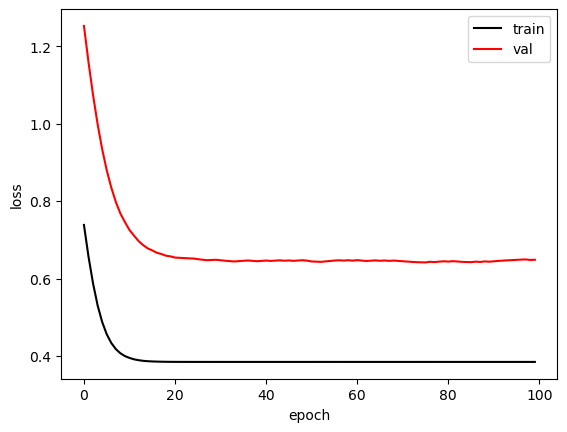

final train mae: 0.385
final val mae:   0.649
final train rmse: 0.506
final train rmse: 0.747


In [7]:
model_1 = build_model_1()
model_1.summary()

history = model_1.fit(
  x=x_train[['total_emission']],
  y=Y_train[['average_temperature_°c']],
  epochs=100,
  batch_size=40,
  validation_data=(
      x_val[['total_emission']],
      Y_val[['average_temperature_°c']]),
  verbose=False)

show_history(history)

### Model 2: Linear Regression (Adam)

</br> Input - Total Emissions
</br>Output - Avg Temp
</br> Requires fewer epochs to converge than standard SGD regression

In [8]:
def build_model_2():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  tot_em = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Total Emissions')

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(tot_em)

  model = tf.keras.Model(inputs=[tot_em],
                         outputs=temp,
                         name='Model_2')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Total Emissions (InputLaye  [(None, 1)]               0         
 r)                                                              
                                                                 
 Temp (Dense)                (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


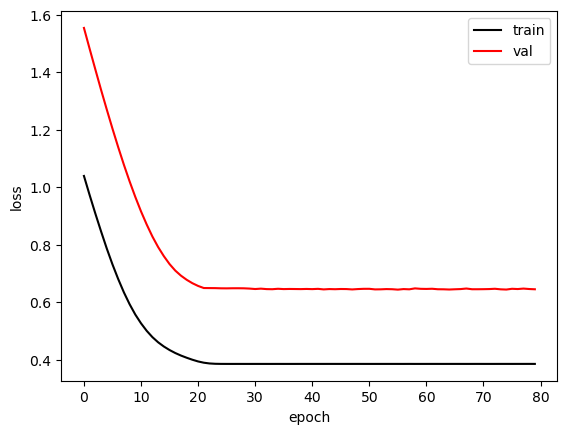

final train mae: 0.385
final val mae:   0.645
final train rmse: 0.506
final train rmse: 0.744


In [9]:
model_2 = build_model_2()
model_2.summary()

history = model_2.fit(
  x=x_train[['total_emission']],
  y=Y_train[['average_temperature_°c']],
  epochs=80,
  batch_size=80,
  validation_data=(
      x_val[['total_emission']],
      Y_val[['average_temperature_°c']]),
  verbose=False)

show_history(history)

### Model 3: Linear Regression (Adam) using Cumulative Sum of Total Emissions

</br> Input - Cumulative Sum of Total Emissions
</br>Output - Avg Temp
</br> Very little difference to Model 2

In [10]:
def build_model_3():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  cum_sum_tot_em = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Cum Sum Total Emissions')

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(cum_sum_tot_em)

  model = tf.keras.Model(inputs=[cum_sum_tot_em],
                         outputs=temp,
                         name='Model_3')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Cum Sum Total Emissions (I  [(None, 1)]               0         
 nputLayer)                                                      
                                                                 
 Temp (Dense)                (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


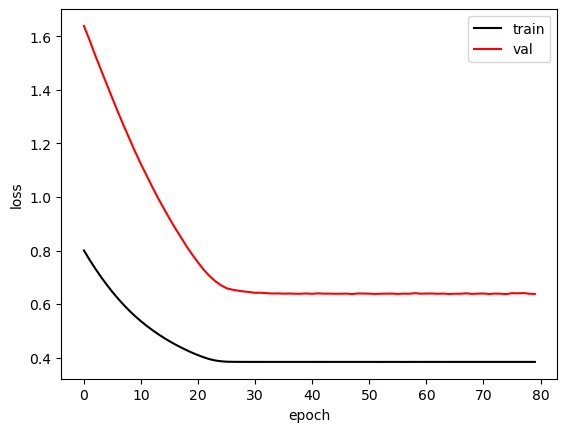

final train mae: 0.384
final val mae:   0.638
final train rmse: 0.505
final train rmse: 0.740


In [11]:
model_3 = build_model_3()
model_3.summary()

history = model_3.fit(
  x=x_train[['cum_sum_total_emission']],
  y=Y_train[['average_temperature_°c']],
  epochs=80,
  batch_size=100,
  validation_data=(
      x_val[['cum_sum_total_emission']],
      Y_val[['average_temperature_°c']]),
  verbose=False)

show_history(history)

### Model 4: Linear Regression (Adam) using Cumulative Sum of Total Emissions & Urban Pop

</br> Input - Cumulative Sum of Total Emissions & Urban Population
</br>Output - Avg Temp
</br> Very little difference to model 3

In [12]:
def build_model_4():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  cum_sum_tot_em = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Cum Sum Total Emissions')
  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')

  features = tf.keras.layers.Concatenate()([cum_sum_tot_em, urban_pop])

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[cum_sum_tot_em, urban_pop],
                         outputs=temp,
                         name='Model_4')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Cum Sum Total Emissions (I  [(None, 1)]                  0         []                            
 nputLayer)                                                                                       
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 concatenate (Concatenate)   (None, 2)                    0         ['Cum Sum Total Emissions[0][0
                                                                    ]',                     

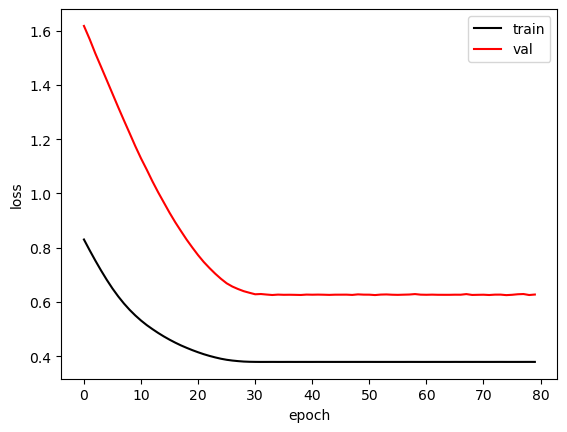

final train mae: 0.380
final val mae:   0.628
final train rmse: 0.501
final train rmse: 0.724


In [13]:
model_4 = build_model_4()
model_4.summary()

history = model_4.fit(
  x={
      'Cum Sum Total Emissions': x_train[['cum_sum_total_emission']],
      'Urban Population': x_train[['log_urban_population']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=80,
  batch_size=100,
  validation_data=(
      {
      'Cum Sum Total Emissions': x_val[['cum_sum_total_emission']],
      'Urban Population': x_val[['log_urban_population']]
    },
      Y_val[['average_temperature_°c']]),
  verbose=False)

show_history(history)

### Model 5: Linear Regression (Adam) Kitchen Sink 

</br> Input - MEI, Urban Pop, All CO2 emission inputs
</br>Output - Avg Temp
</br>Still some noise in validation loss, but shape of loss curves look good and training loss is less than val loss. Could maybe use a few more epochs for convergence. 

In [14]:
def build_model_5():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=['Southern Asia', 'Southern Europe', 
                                                           'Northern Africa', 'Polynesia',
                                                           'Sub-Saharan Africa', 'Latin America and the Caribbean',
                                                           'Australia and New Zealand', 'Western Europe', 
                                                           'Western Asia','Northern America', 'South-eastern Asia', 
                                                           'Eastern Europe','Northern Europe', 'Eastern Asia', 
                                                           'Melanesia','Micronesia', 'Central Asia'], 
                                               output_mode='one_hot')(sub_region)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id])
    
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region],
                         outputs=temp,
                         name='Model_5')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Crop Residues (InputLayer)  [(None, 1)]                  0         []                      

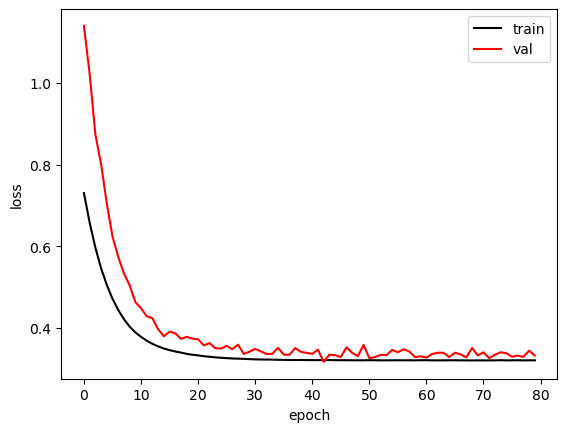

final train mae: 0.320
final val mae:   0.332
final train rmse: 0.435
final train rmse: 0.426


In [15]:
model_5 = build_model_5()
model_5.summary()

history = model_5.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=80,
  batch_size=100,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)

#### Model 6 - Linear Regression (Adam) Kitchen Sink (Hyperparameter Tuning)

</br> Input - MEI, Urban Pop, All CO2 emission inputs
</br>Output - Avg Temp
</br>Added exponential decay learning rate scheduler. Increased epochs and batch size to 300 to try to reduce noise. Small amount of overfitting to training data which is prefereable. Less noise in validation loss. 

In [16]:
def build_model_6():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=['Southern Asia', 'Southern Europe', 
                                                           'Northern Africa', 'Polynesia',
                                                           'Sub-Saharan Africa', 'Latin America and the Caribbean',
                                                           'Australia and New Zealand', 'Western Europe', 
                                                           'Western Asia','Northern America', 'South-eastern Asia', 
                                                           'Eastern Europe','Northern Europe', 'Eastern Asia', 
                                                           'Melanesia','Micronesia','Central Asia'], 
                                               output_mode='one_hot')(sub_region)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id])
    
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region],
                         outputs=temp,
                         name='Model_6')
  
  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Crop Residues (InputLayer)  [(None, 1)]                  0         []                      

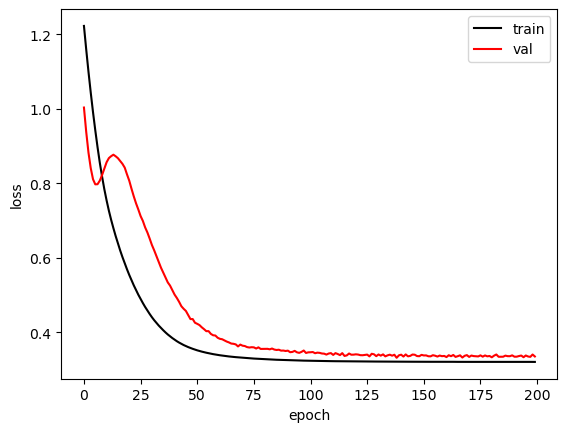

final train mae: 0.320
final val mae:   0.335
final train rmse: 0.435
final train rmse: 0.428


In [17]:
model_6 = build_model_6()
model_6.summary()

history = model_6.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=200,
  batch_size=400,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)

### Model 7: FFNN (1 Hidden Layer)

</br> Input - MEI, Urban Pop, All CO2 emission inputs
</br>Output - Avg Temp
</br>1 Hidden Layer Size: 128
</br>Includes exponential decay LR scheduler
</br> Did not include dropout layer since dropout led to underfitting (val loss was lower than train loss)

In [18]:
def build_model_7():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=['Southern Asia', 'Southern Europe', 
                                                           'Northern Africa', 'Polynesia',
                                                           'Sub-Saharan Africa', 'Latin America and the Caribbean',
                                                           'Australia and New Zealand', 'Western Europe', 
                                                           'Western Asia','Northern America', 'South-eastern Asia', 
                                                           'Eastern Europe','Northern Europe', 'Eastern Asia', 
                                                           'Melanesia','Micronesia', 'Central Asia'], 
                                               output_mode='one_hot')(sub_region)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id])
  
  hidden_1 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_1')(features)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(hidden_1)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region],
                         outputs=temp,
                         name='Model_7')
  
  initial_learning_rate = 0.00001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Crop Residues (InputLayer)  [(None, 1)]                  0         []                      

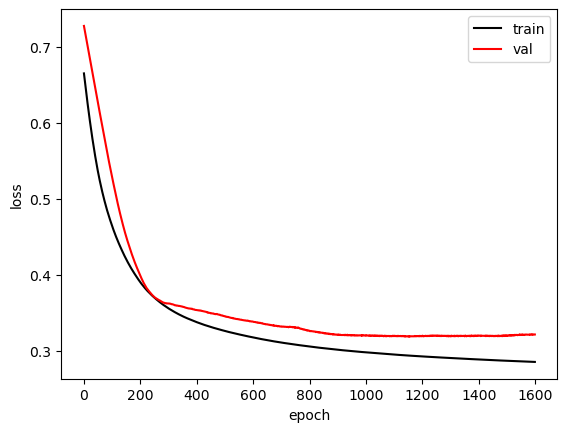

final train mae: 0.285
final val mae:   0.321
final train rmse: 0.396
final train rmse: 0.403


In [19]:
model_7 = build_model_7()
model_7.summary()

history = model_7.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=1600,
  batch_size=600,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)

### Model 8: FFNN (2 Hidden Layers)

</br> Input - MEI, Urban Pop, All CO2 emission inputs
</br>Output - Avg Temp
</br>1st Hidden Layer Size: 128
</br>2nd Hidden Layer Size: 128
</br>Includes exponential decay LR scheduler
</br> Did not include dropout layer since dropout led to underfitting (val loss was lower than train loss)

In [20]:
def build_model_8():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  # region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=['Southern Asia', 'Southern Europe', 
                                                           'Northern Africa', 'Polynesia',
                                                           'Sub-Saharan Africa', 'Latin America and the Caribbean',
                                                           'Australia and New Zealand', 'Western Europe', 
                                                           'Western Asia','Northern America', 'South-eastern Asia', 
                                                           'Eastern Europe','Northern Europe', 'Eastern Asia', 
                                                           'Melanesia','Micronesia','Central Asia'], 
                                               output_mode='one_hot')(sub_region)

  # region_id = tf.keras.layers.StringLookup(vocabulary=['Asia', 'Europe', 'Africa', 'Americas', 'Oceania'], 
  #                                              output_mode='one_hot')(region)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id
                                            # , region_id
                                           ])
  
  hidden_1 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_1')(features)

  hidden_2 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_2')(hidden_1)

  # dropout_1 = tf.keras.layers.Dropout(0.1, name='Dropout_1')(hidden_2)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(hidden_2)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region
                                            # , region
                                            ],
                         outputs=temp,
                         name='Model_8')
  
  initial_learning_rate = 0.00001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Crop Residues (InputLayer)  [(None, 1)]                  0         []                      

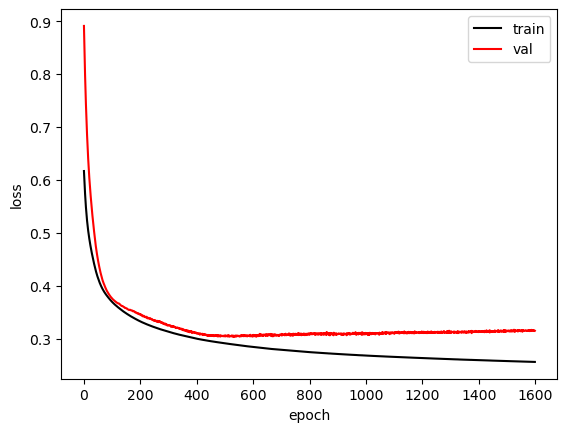

final train mae: 0.256
final val mae:   0.315
final train rmse: 0.368
final train rmse: 0.393


In [21]:
model_8 = build_model_8()
model_8.summary()

history = model_8.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']]
      # ,
      # 'Region': x_train[['region']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=1600,
  batch_size=500,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']]
      #     ,
      # 'Region': x_val[['region']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)

### Model 9: FFNN (3 Hidden Layers)

</br> Input - MEI, Urban Pop, All CO2 emission inputs
</br>Output - Avg Temp
</br>1st Hidden Layer Size: 128
</br>2nd Hidden Layer Size: 128
</br>3rd Hidden Layer Size: 128
</br>Includes exponential decay LR scheduler
</br> Did not include dropout layer since dropout led to underfitting (val loss was lower than train loss)

In [22]:
def build_model_9():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  # region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=['Southern Asia', 'Southern Europe', 
                                                           'Northern Africa', 'Polynesia',
                                                           'Sub-Saharan Africa', 'Latin America and the Caribbean',
                                                           'Australia and New Zealand', 'Western Europe', 
                                                           'Western Asia','Northern America', 'South-eastern Asia', 
                                                           'Eastern Europe','Northern Europe', 'Eastern Asia', 
                                                           'Melanesia','Micronesia','Central Asia'], 
                                               output_mode='one_hot')(sub_region)

  # region_id = tf.keras.layers.StringLookup(vocabulary=['Asia', 'Europe', 'Africa', 'Americas', 'Oceania'], 
  #                                              output_mode='one_hot')(region)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id
                                            # , region_id
                                           ])
  
  hidden_1 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_1')(features)

  hidden_2 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_2')(hidden_1)

  hidden_3 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_3')(hidden_2)

  # dropout_1 = tf.keras.layers.Dropout(0.1, name='Dropout_1')(hidden_2)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(hidden_3)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region
                                            # , region
                                            ],
                         outputs=temp,
                         name='Model_9')
  
  initial_learning_rate = 0.000001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

In [ ]:
model_9 = build_model_9()
model_9.summary()

history = model_9.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']]
      # ,
      # 'Region': x_train[['region']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=2400,
  batch_size=400,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']]
      #     ,
      # 'Region': x_val[['region']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)

Model: "Model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Crop Residues (InputLayer)  [(None, 1)]                  0         []                      

### Model 10: LSTM (Long Short Term Memory)

</br> Input - MEI, Urban Pop, All CO2 emission inputs
</br>Output - Avg Temp
</br>Includes exponential decay LR scheduler
</br> Did not include dropout layer since dropout led to underfitting (val loss was lower than train loss)

In [ ]:
def build_model_10():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  # region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=['Southern Asia', 'Southern Europe', 
                                                           'Northern Africa', 'Polynesia',
                                                           'Sub-Saharan Africa', 'Latin America and the Caribbean',
                                                           'Australia and New Zealand', 'Western Europe', 
                                                           'Western Asia','Northern America', 'South-eastern Asia', 
                                                           'Eastern Europe','Northern Europe', 'Eastern Asia', 
                                                           'Melanesia','Micronesia','Central Asia'], 
                                               output_mode='one_hot')(sub_region)

  # region_id = tf.keras.layers.StringLookup(vocabulary=['Asia', 'Europe', 'Africa', 'Americas', 'Oceania'], 
  #                                              output_mode='one_hot')(region)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id
                                            # , region_id
                                           ])
  
  lstm_layer = tf.keras.layers.LSTM(
        units=200,
        input_shape=(None,30),
        #recurrent_dropout=0.4,
        #use_bias=True,
        return_sequences=True,
        name='LSTM')(features)   

  # dropout_1 = tf.keras.layers.Dropout(0.1, name='Dropout_1')(hidden_2)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(lstm_layer)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region
                                            # , region
                                            ],
                         outputs=temp,
                         name='Model_10')
  
  initial_learning_rate = 0.00001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

In [ ]:
model_10 = build_model_10()
model_10.summary()

history = model_10.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']]
      # ,
      # 'Region': x_train[['region']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=2000,
  batch_size=400,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']]
      #     ,
      # 'Region': x_val[['region']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)

In [ ]:
features = ['urban_population',
            'mei',
            'cum_sum_log_crop_residues',
            'cum_sum_log_rice_cultivation',
            'cum_sum_log_drained_organic_soils_co2',
            'cum_sum_log_net_forest_conversion',
            'cum_sum_log_fires',
            'cum_sum_log_manure_mgmt',
            'cum_sum_log_food_systems',
            'cum_sum_log_ippu_tot',
            'cum_sum_log_on_farm_energy_use',
            'cum_sum_forestland']
# features_len = len(features)
model_lstm = build_lstm_model(12)
output = model_lstm(x_train[features])

In [ ]:
x_train_temp = x_train.sort_values(['area','year']).reset_index(drop=True)
x_train_temp.shape

In [ ]:
agg_x_train = x_train_temp.groupby('area').sum()
agg_x_train.head()

In [ ]:
agg_x_train = agg_x_train[agg_x_train['year'] != 50050]
agg_x_train.index


In [ ]:
countries = ['Armenia', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
       'Croatia', 'Czechia', 'Eritrea', 'Estonia', 'Georgia', 'Kazakhstan',
       'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Marshall Islands',
       'Micronesia (Federated States of)', 'North Macedonia',
       'Republic of Moldova', 'Russian Federation', 'Slovakia', 'Slovenia',
       'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan']

for country in countries:
    x_train_temp = x_train_temp[x_train_temp['area'] != country]

In [ ]:
x_train_temp

In [ ]:
x_train_temp['area'].nunique()

In [ ]:
x_train_temp = np.array(x_train_temp)
# x_train.reshape((164, 25, 38))

In [ ]:
x_train_temp.shape

In [ ]:
x_train_temp = x_train_temp.reshape((164, 25, 38))

In [ ]:
x_train_temp.shape